# Variational API quickstart

:::{post} Sept 15, 2021
:tags: variational inference
:category: beginner
:::

The variational inference (VI) API is focused on approximating posterior distributions for Bayesian models. Common use cases to which this module can be applied include:

* Sampling from model posterior and computing arbitrary expressions
* Conduct Monte Carlo approximation of expectation, variance, and other statistics
* Remove symbolic dependence on PyMC3 random nodes and evaluate expressions (using `eval`)
* Provide a bridge to arbitrary Theano code

Sounds good, doesn't it?

The module provides an interface to a variety of inference methods, so you are free to choose what is most appropriate for the problem.

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano

pm.set_tt_rng(42)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Basic setup

We do not need complex models to play with the VI API; let's begin with a simple mixture model:

In [3]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])

with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

We can't compute analytical expectations for this model. However, we can obtain an approximation using Markov chain Monte Carlo methods; let's use NUTS first. 

To allow samples of the expressions to be saved, we need to wrap them in `Deterministic` objects:

In [4]:
with model:
    pm.Deterministic("x2", x2)
    pm.Deterministic("sin_x", sin_x)

In [5]:
with model:
    trace = pm.sample(50000, return_inferencedata=False)
    idata = az.convert_to_inference_data(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 0.9065100242191079, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


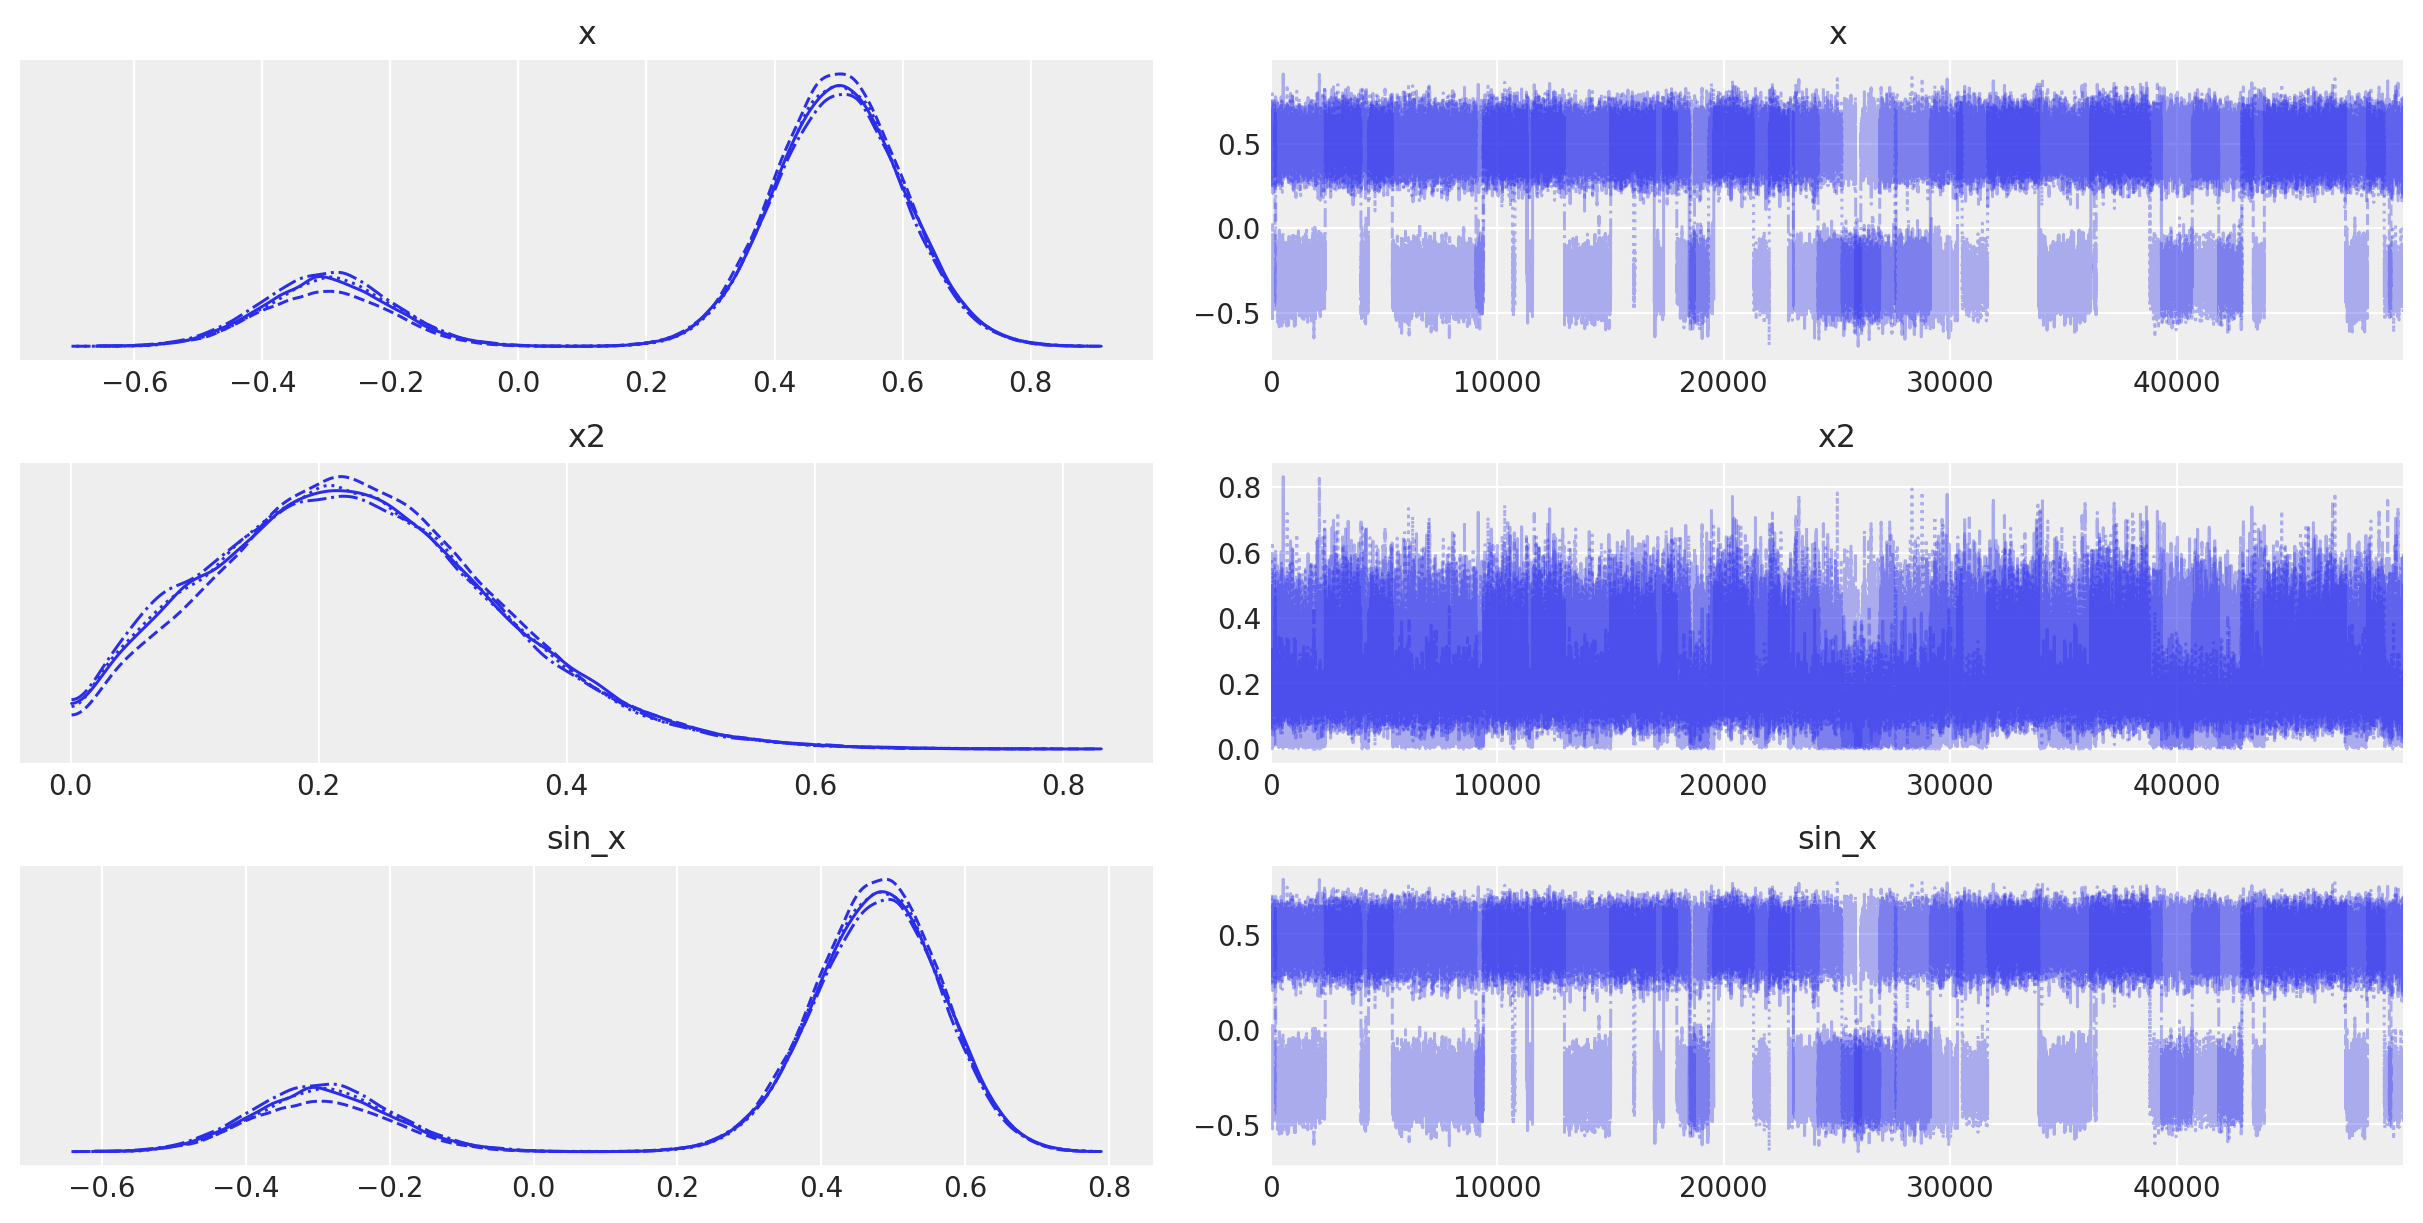

In [6]:
az.plot_trace(idata);

Above are traces for $x^2$ and $sin(x)$. We can see there is clear multi-modality in this model. One drawback, is that you need to know in advance what exactly you want to see in trace and wrap it with `Deterministic`.

The VI API takes an alternate approach: You obtain inference from model, then calculate expressions based on this model afterwards. 

Let's use the same model:

In [7]:
with pm.Model() as model:

    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

Here we will use automatic differentiation variational inference (ADVI).

In [8]:
with model:
    mean_field = pm.fit(method="advi")

/home/ada/.local/lib/python3.8/site-packages/theano/gpuarray/dnn.py:192: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn(


Finished [100%]: Average Loss = 2.2687


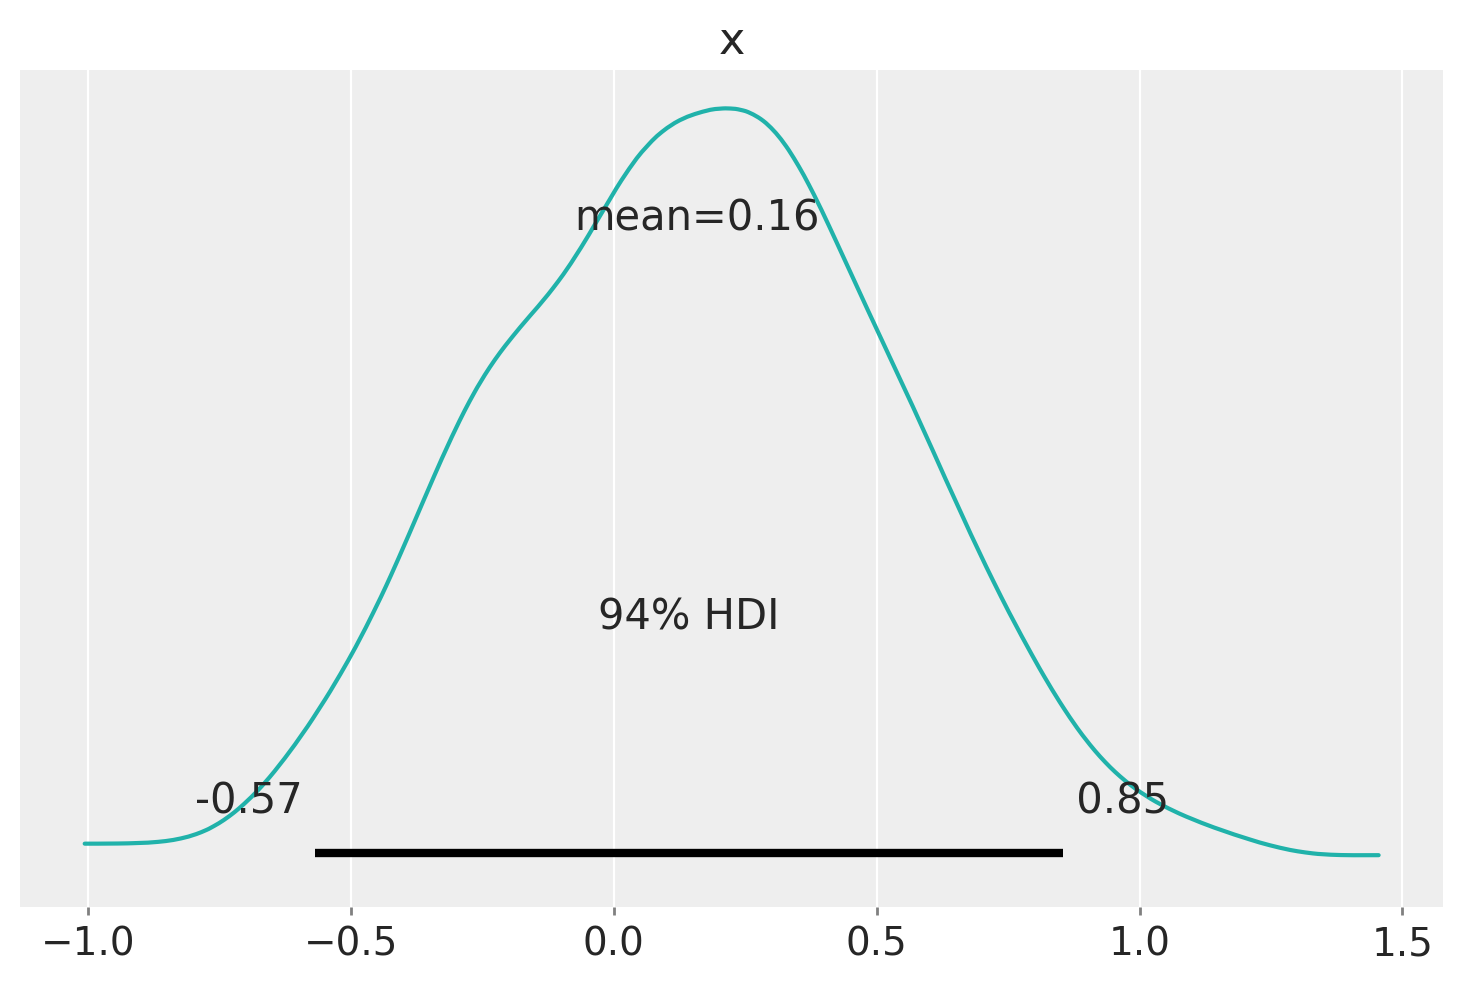

In [9]:
with model:
    az.plot_posterior(mean_field.sample(1000), color="LightSeaGreen");

Notice that ADVI has failed to approximate the multimodal distribution, since it uses a Gaussian distribution that has a single mode.

## Checking convergence

In [10]:
help(pm.callbacks.CheckParametersConvergence)

Help on class CheckParametersConvergence in module pymc3.variational.callbacks:

class CheckParametersConvergence(Callback)
 |  CheckParametersConvergence(every=100, tolerance=0.001, diff='relative', ord=inf)
 |  
 |  Convergence stopping check
 |  
 |  Parameters
 |  ----------
 |  every: int
 |      check frequency
 |  tolerance: float
 |      if diff norm < tolerance: break
 |  diff: str
 |      difference type one of {'absolute', 'relative'}
 |  ord: {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
 |      see more info in :func:`numpy.linalg.norm`
 |  
 |  Examples
 |  --------
 |  >>> with model:
 |  ...     approx = pm.fit(
 |  ...         n=10000, callbacks=[
 |  ...             CheckParametersConvergence(
 |  ...                 every=50, diff='absolute',
 |  ...                 tolerance=1e-4)
 |  ...         ]
 |  ...     )
 |  
 |  Method resolution order:
 |      CheckParametersConvergence
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __

Let's use the default arguments for `CheckParametersConvergence` as they seem to be reasonable.

In [11]:
from pymc3.variational.callbacks import CheckParametersConvergence

with model:
    mean_field = pm.fit(method="advi", callbacks=[CheckParametersConvergence()])

Finished [100%]: Average Loss = 2.2763


We can access inference history via `.hist` attribute.

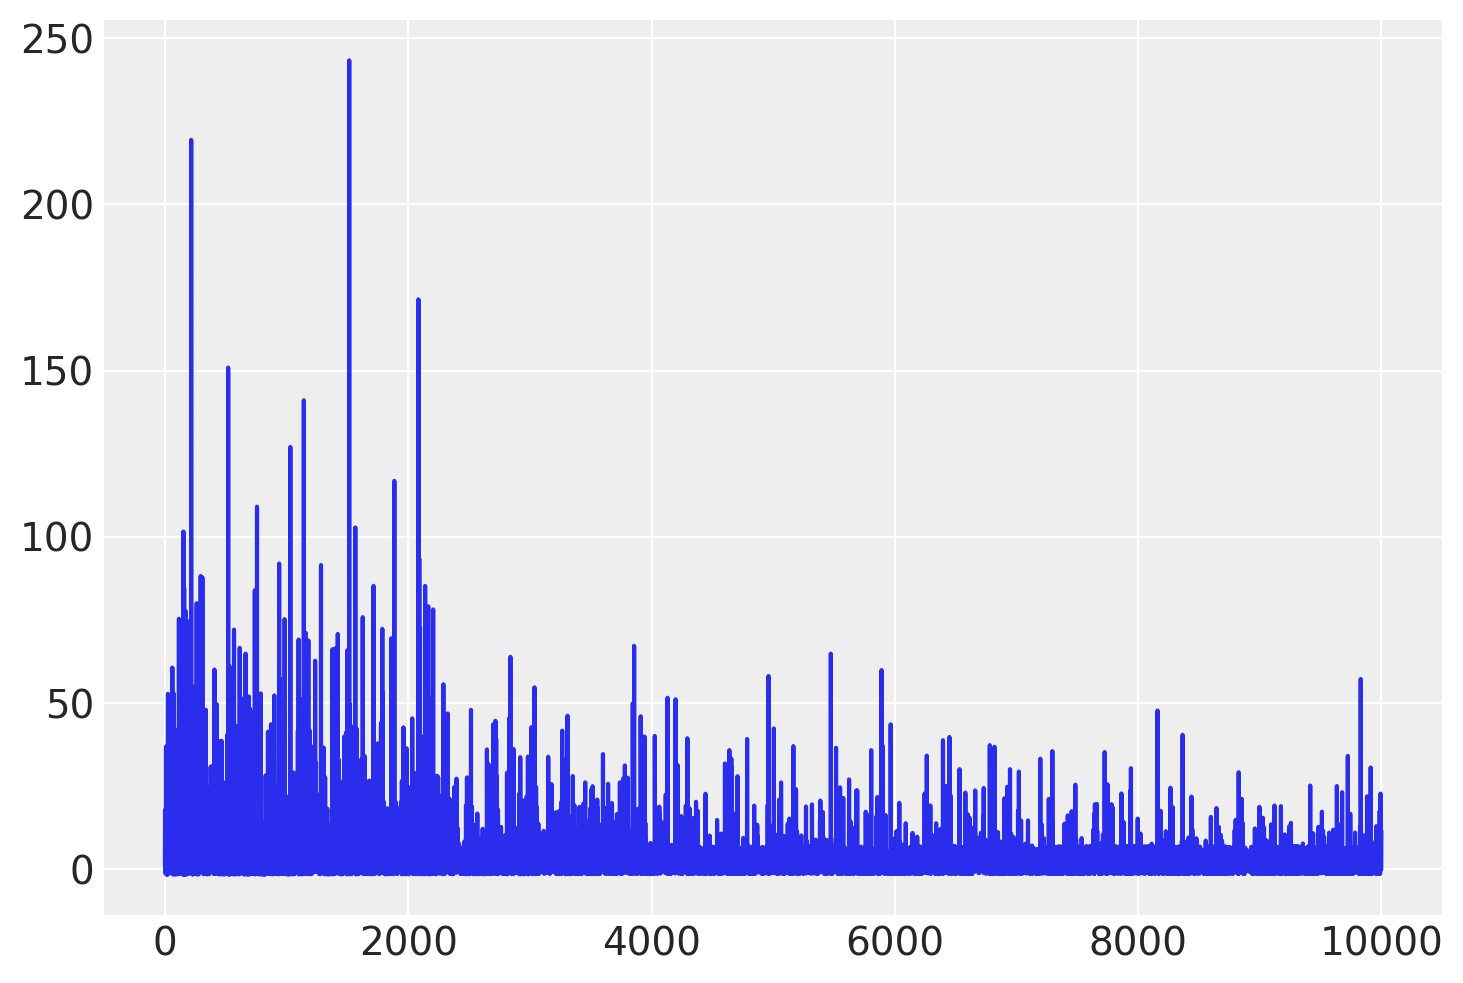

In [12]:
plt.plot(mean_field.hist);

This is not a good convergence plot, despite the fact that we ran many iterations. The reason is that the mean of the ADVI approximation is close to zero, and therefore taking the relative difference (the default method) is unstable for checking convergence.

In [13]:
with model:
    mean_field = pm.fit(
        method="advi", callbacks=[pm.callbacks.CheckParametersConvergence(diff="absolute")]
    )

Convergence achieved at 4700
Interrupted at 4,699 [46%]: Average Loss = 4.7996


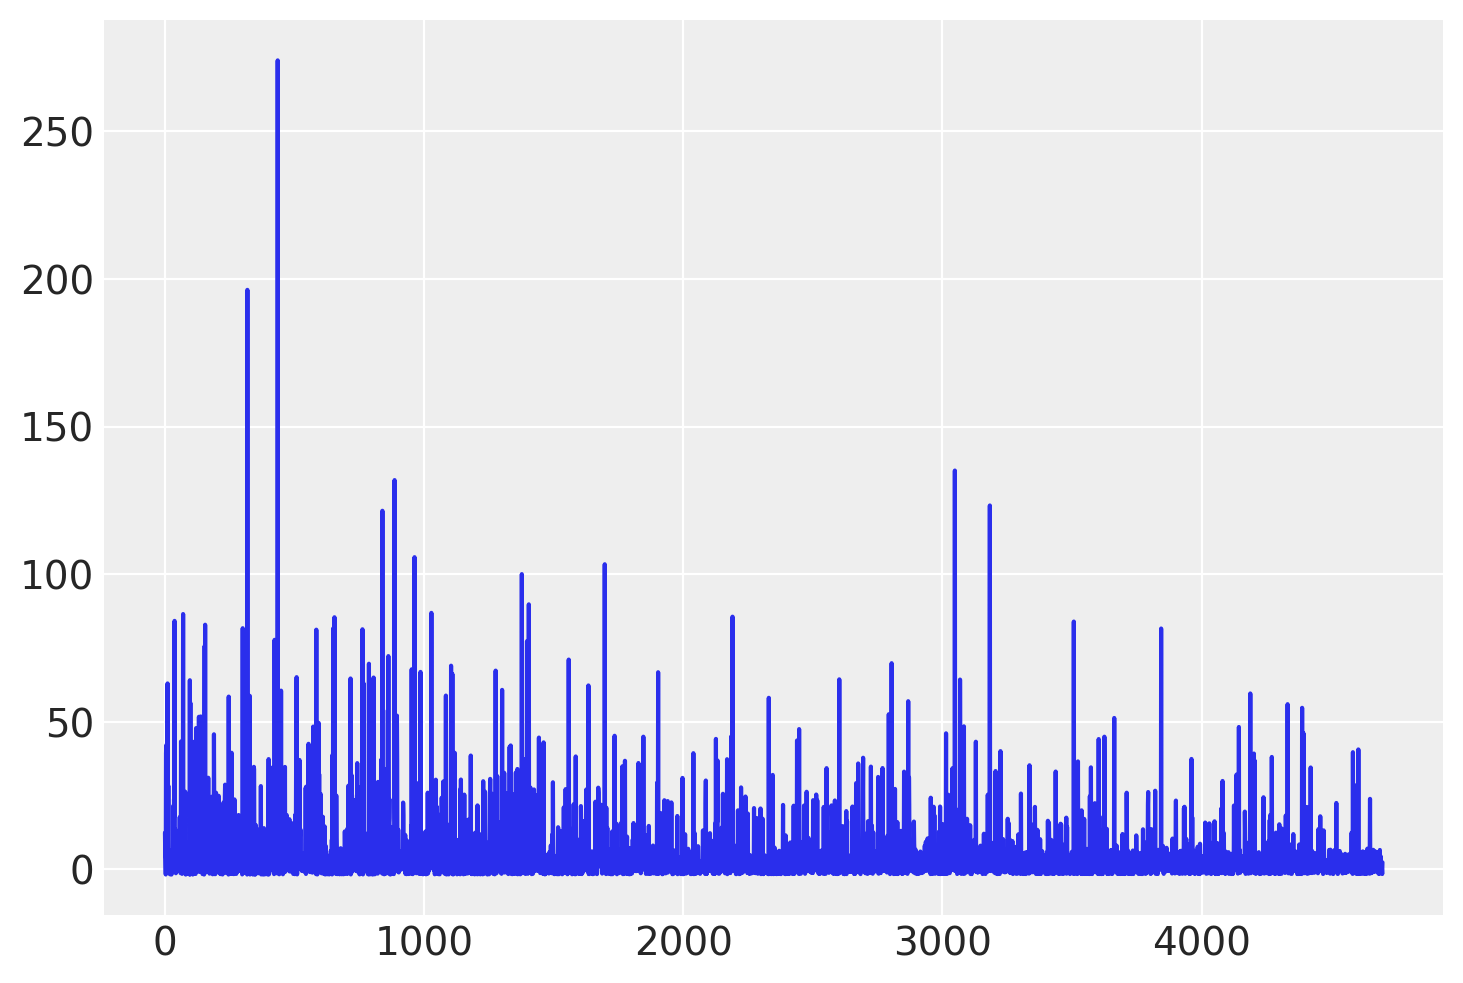

In [14]:
plt.plot(mean_field.hist);

That's much better! We've reached convergence after less than 5000 iterations.

## Tracking parameters

Another usefull callback allows users to track parameters. It allows for the tracking of arbitrary statistics during inference, though it can be memory-hungry. Using the `fit` function, we do not have direct access to the approximation before inference. However, tracking parameters requires access to the approximation. We can get around this constraint by using the object-oriented (OO) API for inference.

In [15]:
with model:
    advi = pm.ADVI()

In [16]:
advi.approx

Different approximations have different hyperparameters. In mean-field ADVI, we have $\rho$ and $\mu$ (inspired by {cite:p}`blundell2015weight`).

In [17]:
advi.approx.shared_params

{'mu': mu, 'rho': rho}

There are convenient shortcuts to relevant statistics associated with the approximation. This can be useful, for example, when specifying a mass matrix for NUTS sampling:

In [18]:
advi.approx.mean.eval(), advi.approx.std.eval()

(array([0.34]), array([0.69314718]))

We can roll these statistics into the `Tracker` callback.

In [19]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval,  # callable that returns std
)

Now, calling `advi.fit` will record the mean and standard deviation of the approximation as it runs.

In [20]:
approx = advi.fit(20000, callbacks=[tracker])

Finished [100%]: Average Loss = 1.9589


We can now plot both the evidence lower bound and parameter traces:

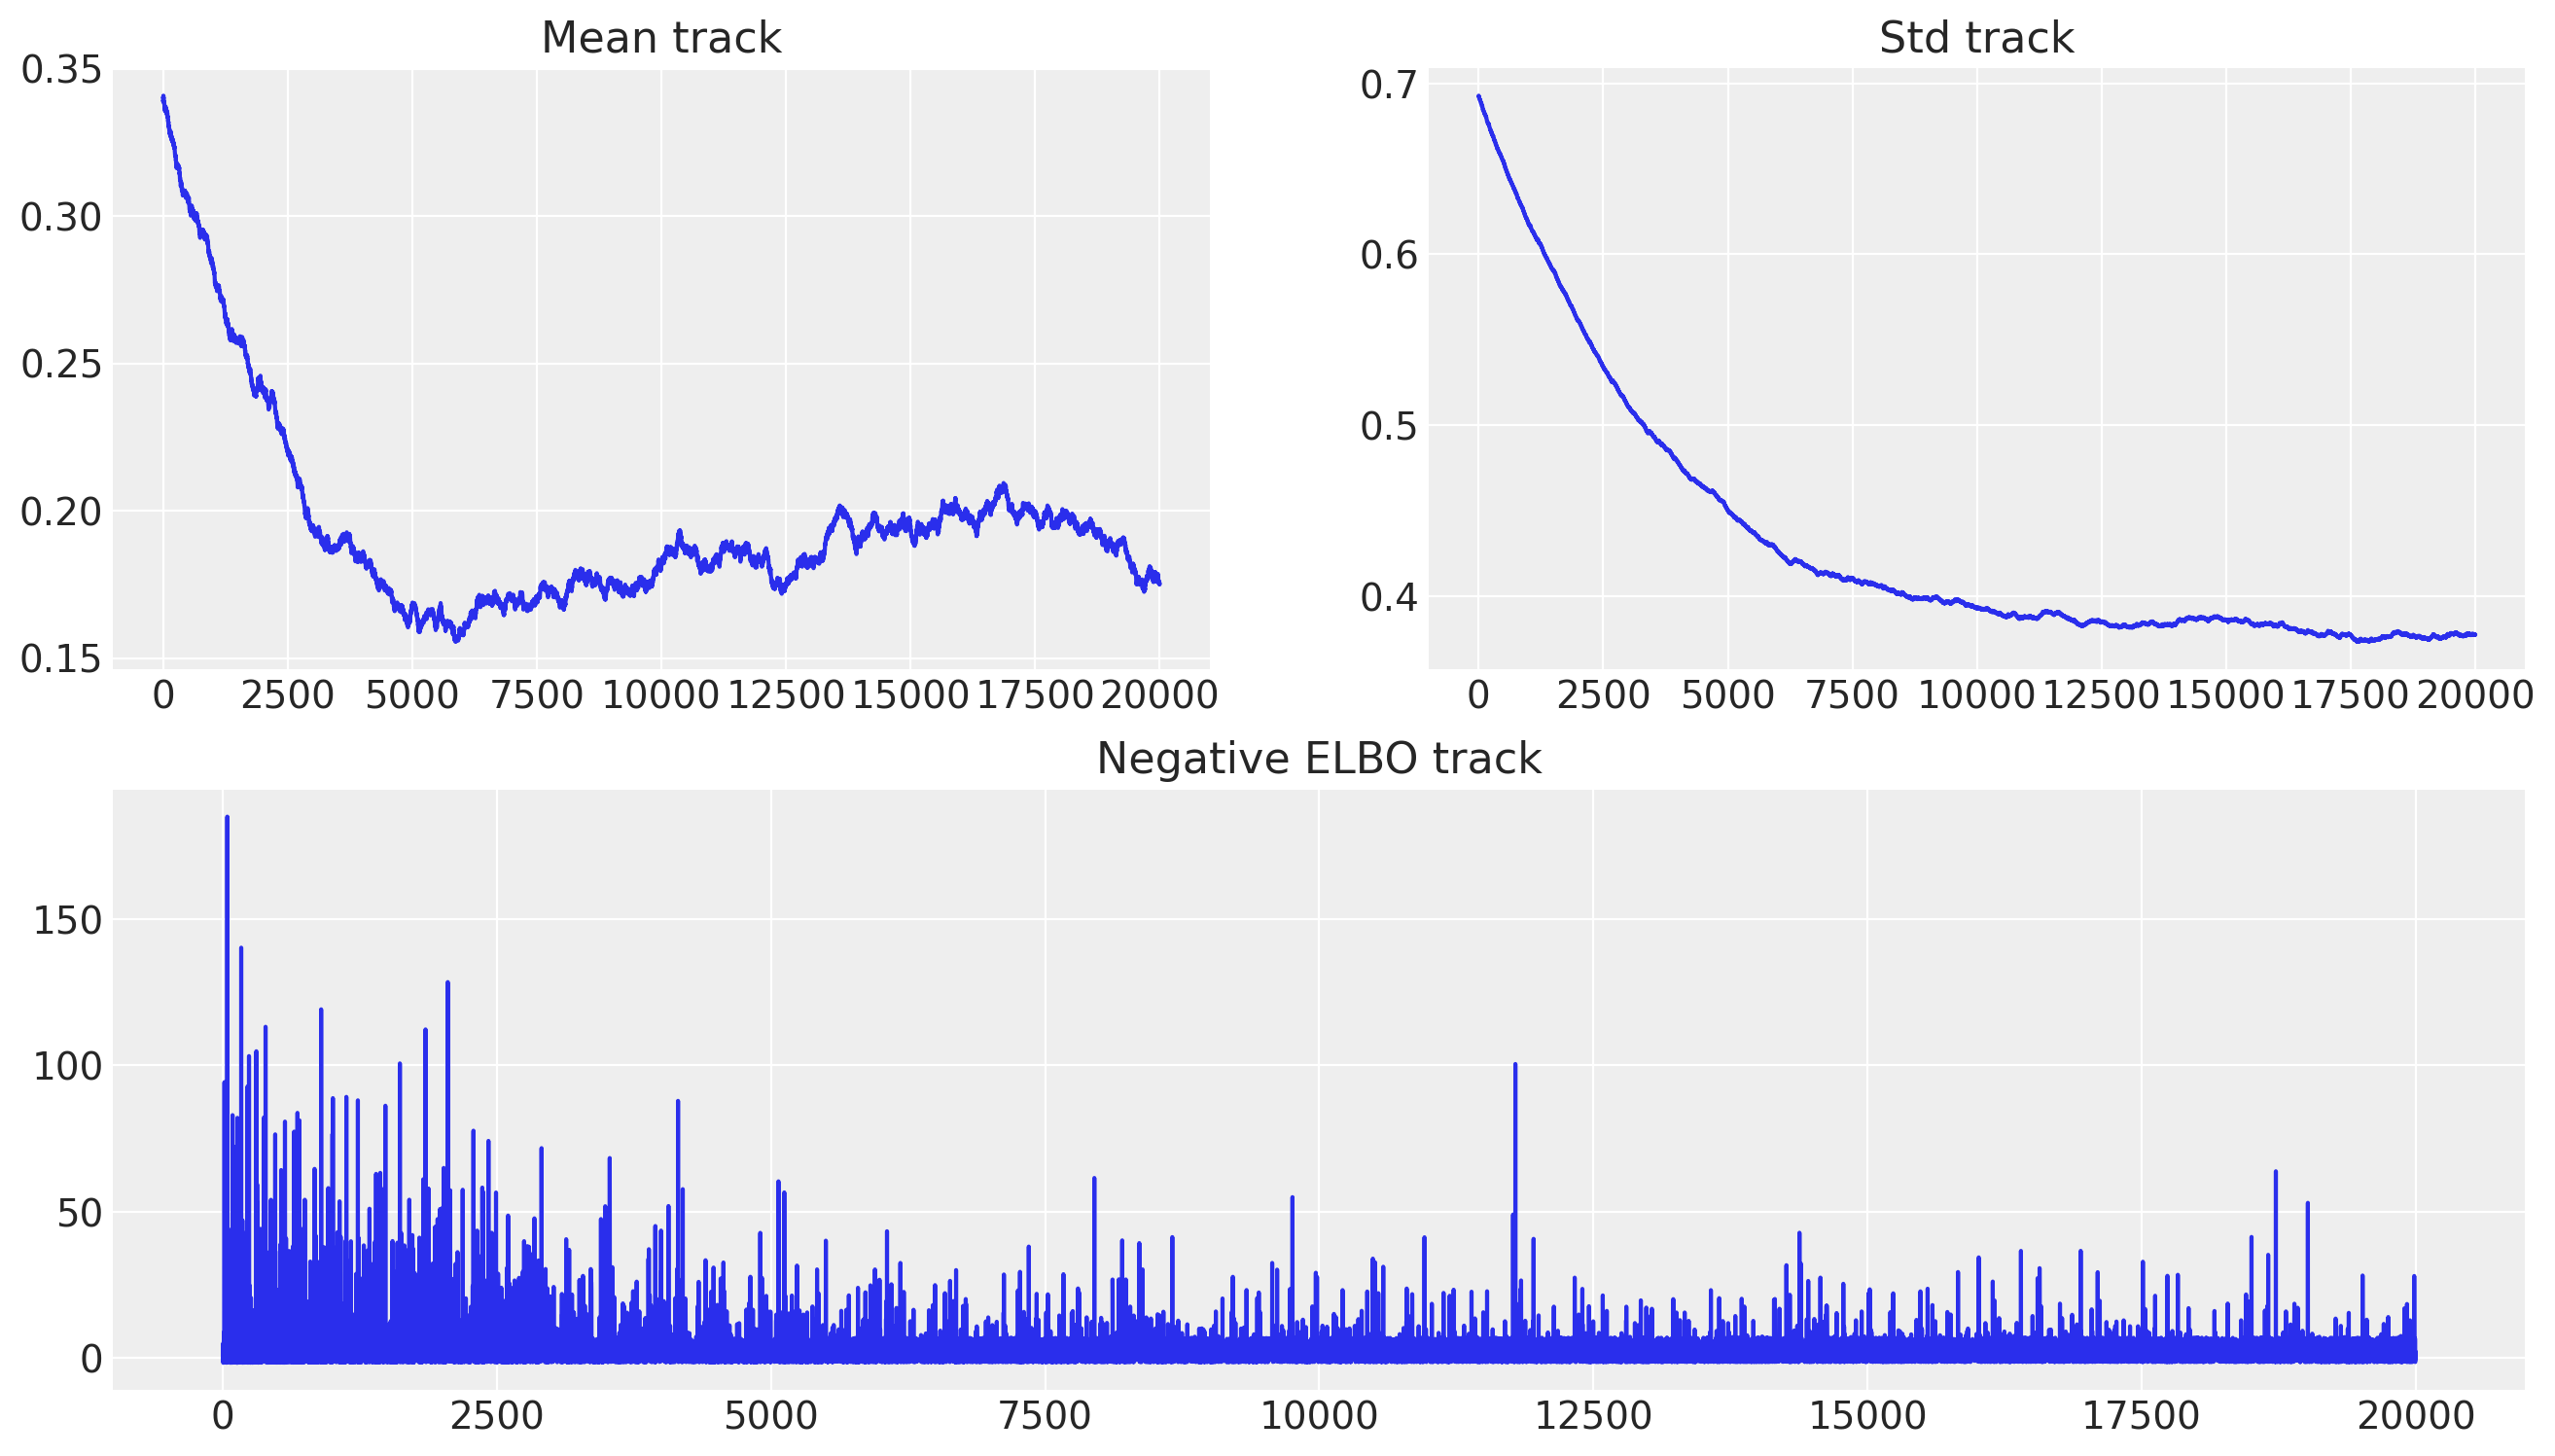

In [21]:
fig = plt.figure(figsize=(16, 9), constrained_layout=False)
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean track")
std_ax.plot(tracker["std"])
std_ax.set_title("Std track")
hist_ax.plot(advi.hist)
hist_ax.set_title("Negative ELBO track");

Notice that there are convergence issues with the mean, and that lack of convergence does not seem to change the ELBO trajectory significantly. As we are using the OO API, we can run the approximation longer until convergence is achieved.

In [22]:
advi.refine(100000)

Finished [100%]: Average Loss = 1.8422


Let's take a look:

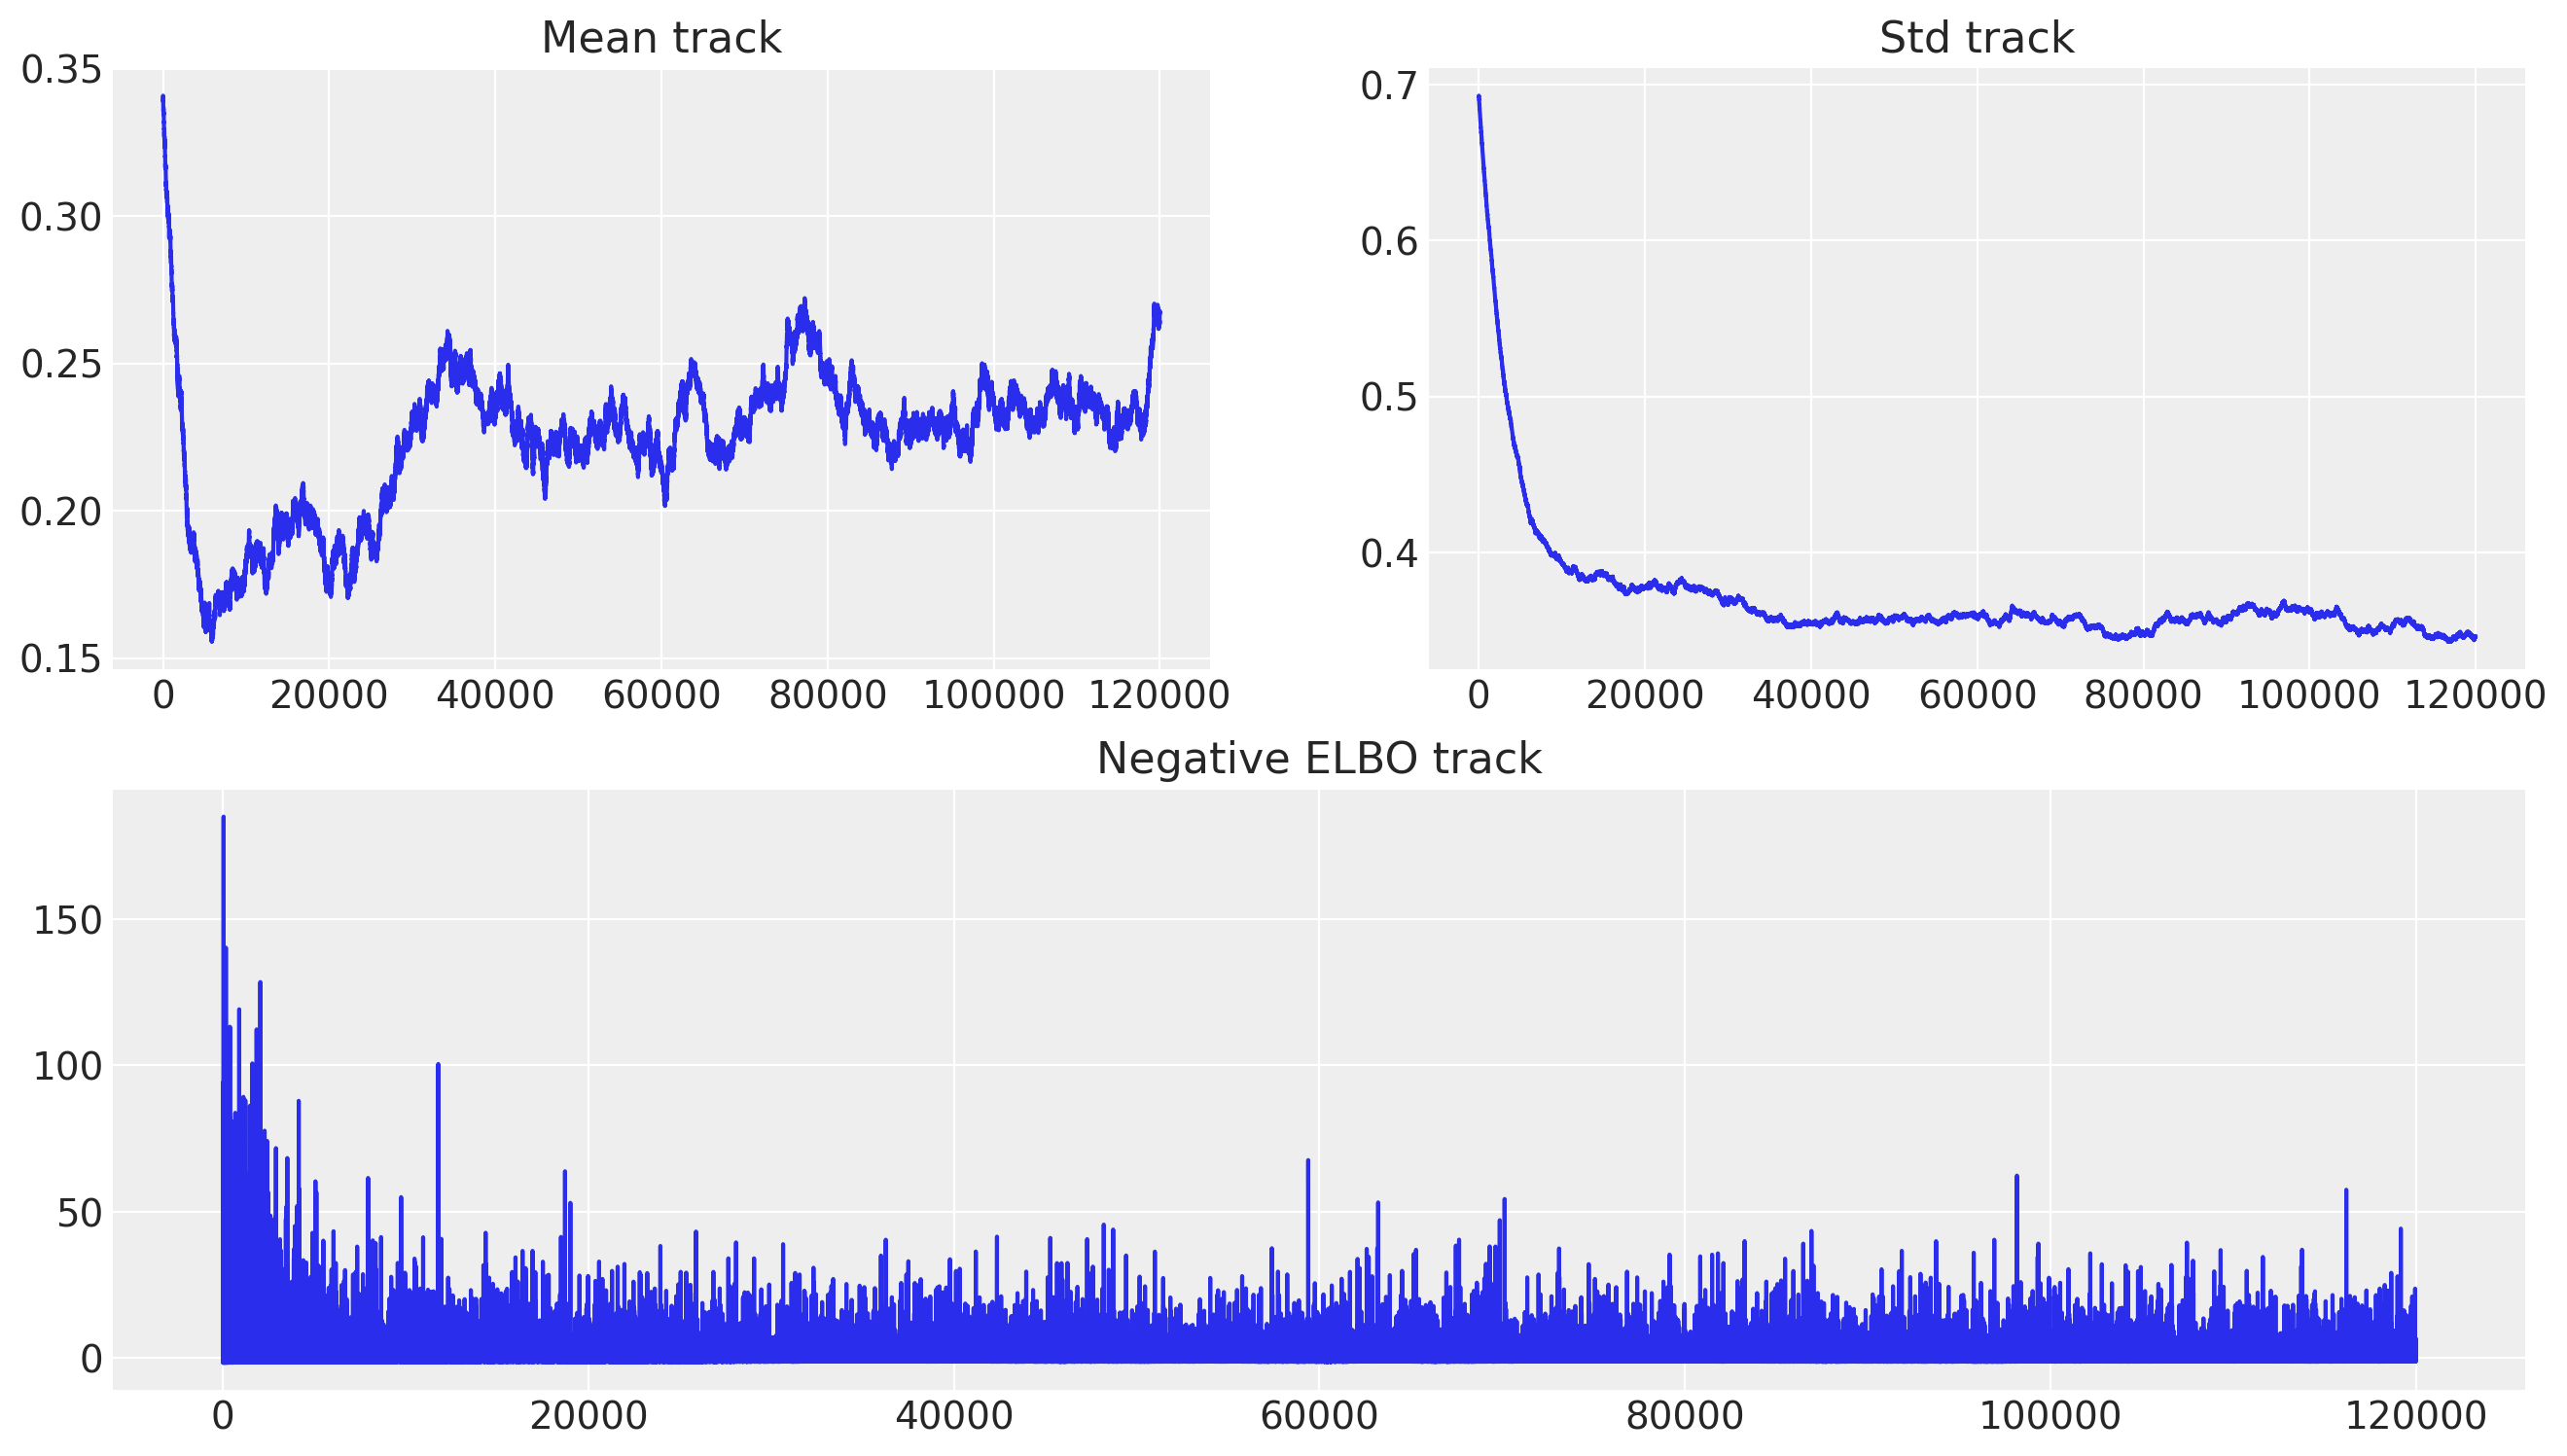

In [23]:
fig = plt.figure(figsize=(16, 9), constrained_layout=False)
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean track")
std_ax.plot(tracker["std"])
std_ax.set_title("Std track")
hist_ax.plot(advi.hist)
hist_ax.set_title("Negative ELBO track");

We still see evidence for lack of convergence, as the mean has devolved into a random walk. This could be the result of choosing a poor algorithm for inference. At any rate, it is unstable and can produce very different results even using different random seeds.

Let's compare results with the NUTS output:

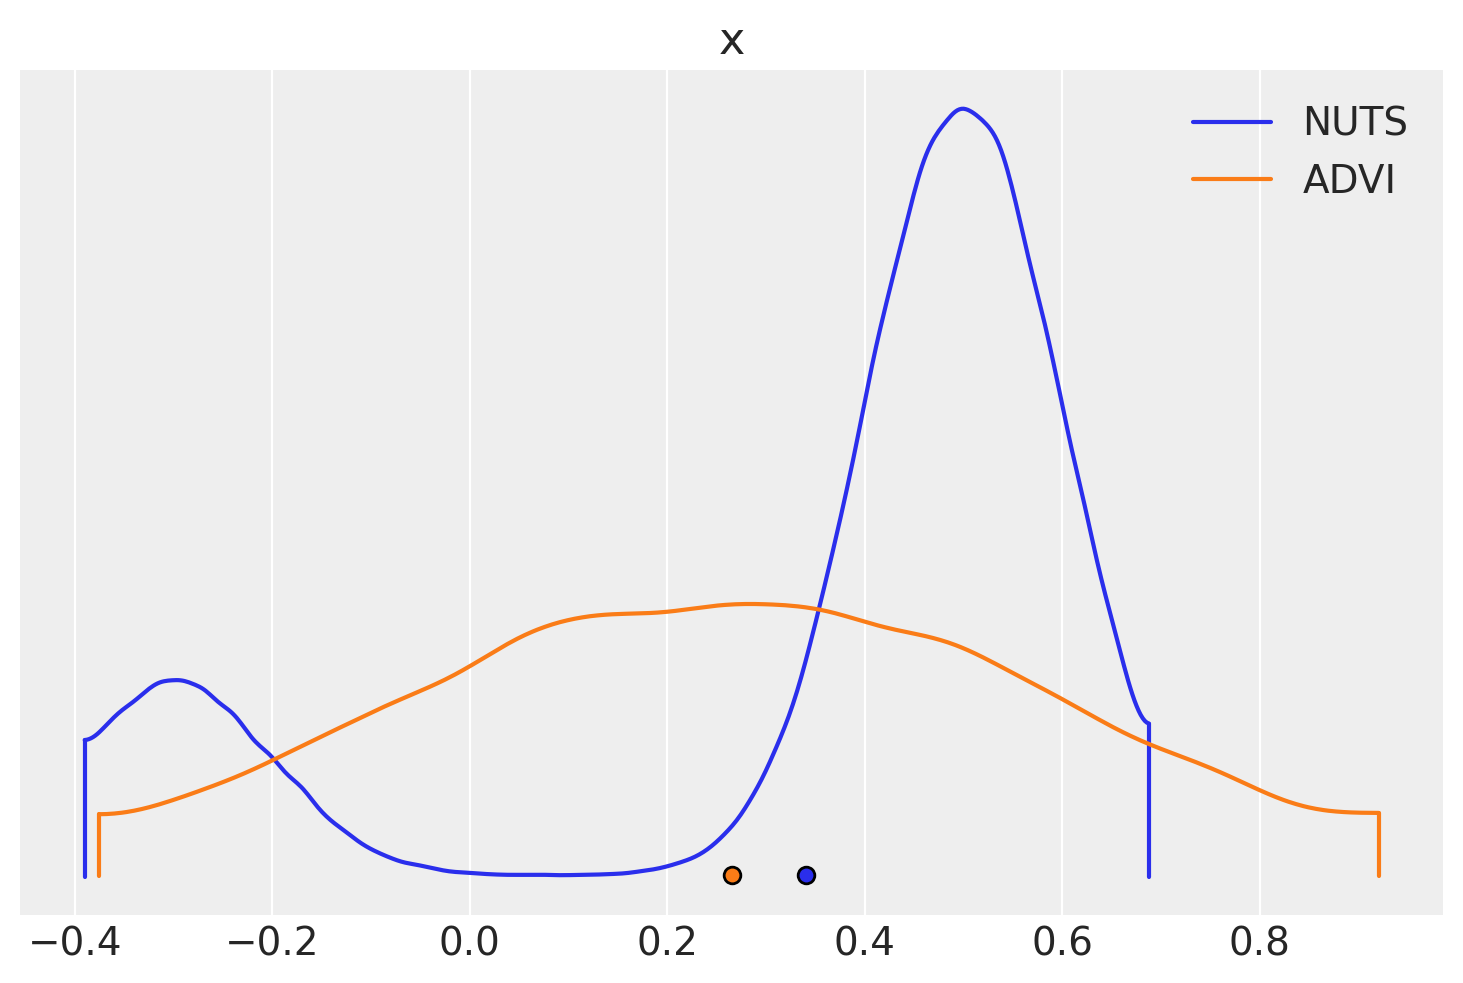

In [24]:
with model:
    az.plot_density([idata.posterior["x"], approx.sample(10000)["x"]], data_labels=["NUTS", "ADVI"]);

Again, we see that ADVI is not able to cope with multimodality; we can instead use SVGD, which generates an approximation based on a large number of particles.

In [25]:
with model:
    svgd_approx = pm.fit(
        300,
        method="svgd",
        inf_kwargs=dict(n_particles=1000),
        obj_optimizer=pm.sgd(learning_rate=0.01),
    )

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


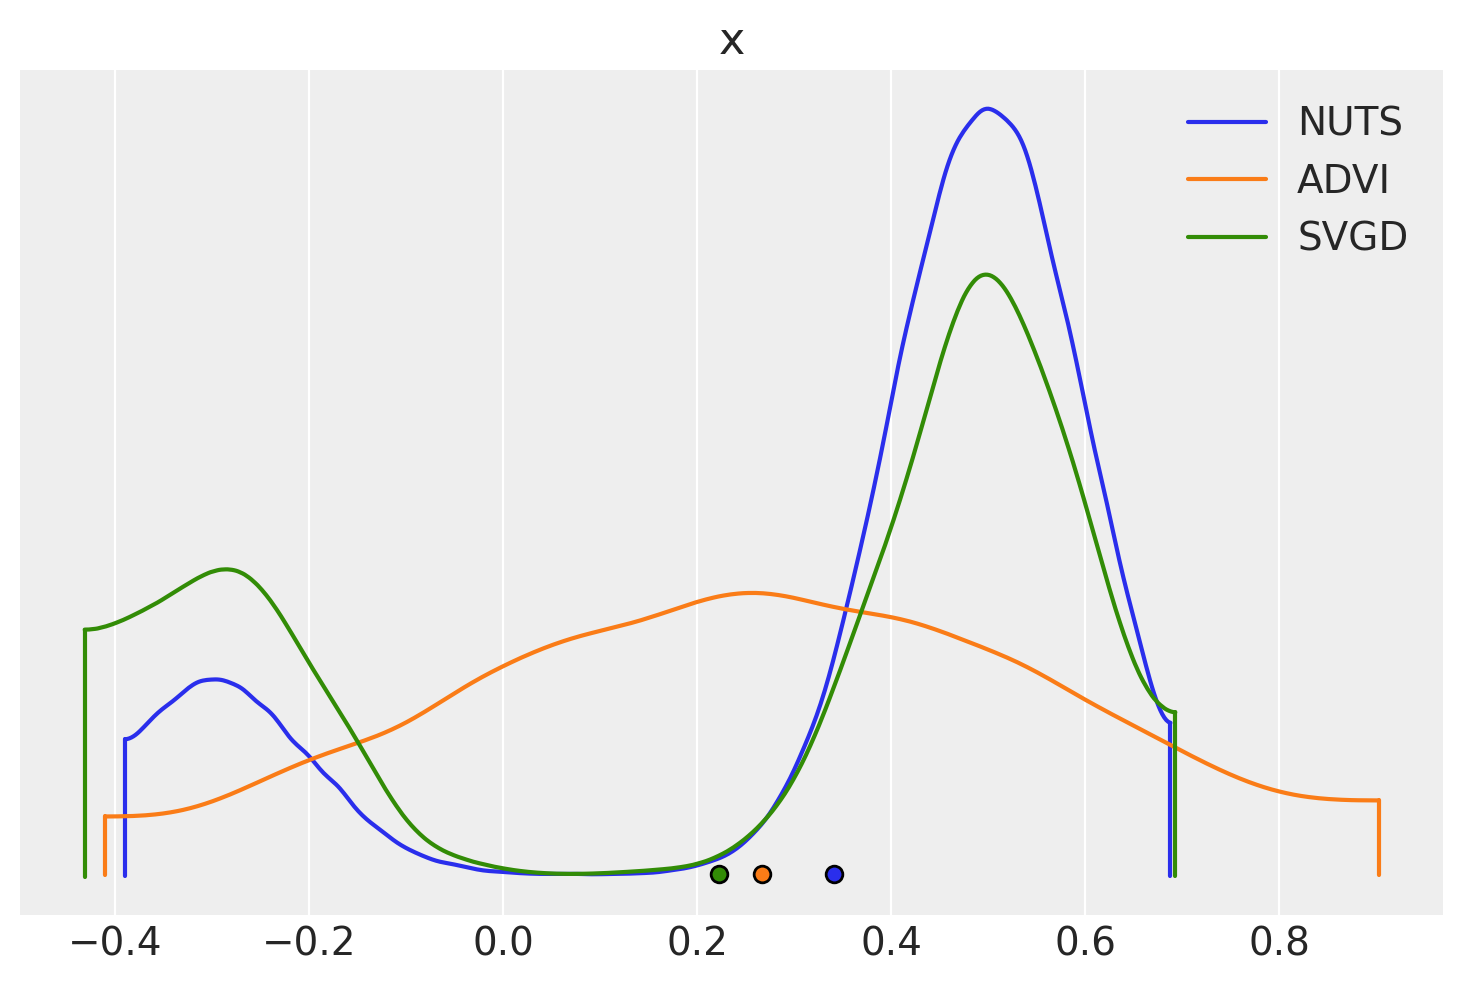

In [26]:
with model:
    az.plot_density(
        [idata.posterior["x"], approx.sample(10000)["x"], svgd_approx.sample(2000)["x"]],
        data_labels=["NUTS", "ADVI", "SVGD"],
    )

That did the trick, as we now have a multimodal approximation using SVGD. 

With this, it is possible to calculate arbitrary functions of the parameters with this variational approximation. For example we can calculate $x^2$ and $sin(x)$, as with the NUTS model.

In [27]:
# recall x ~ NormalMixture
a = x ** 2
b = pm.math.sin(x)

To evaluate these expressions with the approximation, we need `approx.sample_node`.

In [28]:
help(svgd_approx.sample_node)

Help on method sample_node in module pymc3.variational.opvi:

sample_node(node, size=None, deterministic=False, more_replacements=None) method of pymc3.variational.approximations.Empirical instance
    Samples given node or nodes over shared posterior
    
    Parameters
    ----------
    node: Theano Variables (or Theano expressions)
    size: None or scalar
        number of samples
    more_replacements: `dict`
        add custom replacements to graph, e.g. change input source
    deterministic: bool
        whether to use zeros as initial distribution
        if True - zero initial point will produce constant latent variables
    
    Returns
    -------
    sampled node(s) with replacements



In [29]:
a_sample = svgd_approx.sample_node(a)
a_sample.eval()

array(0.12756186)

In [30]:
a_sample.eval()

array(0.17445159)

In [31]:
a_sample.eval()

array(0.09569608)

Every call yields a different value from the same theano node. This is because it is **stochastic**. 

By applying replacements, we are now free of the dependence on the PyMC3 model; instead, we now depend on the approximation. Changing it will change the distribution for stochastic nodes:

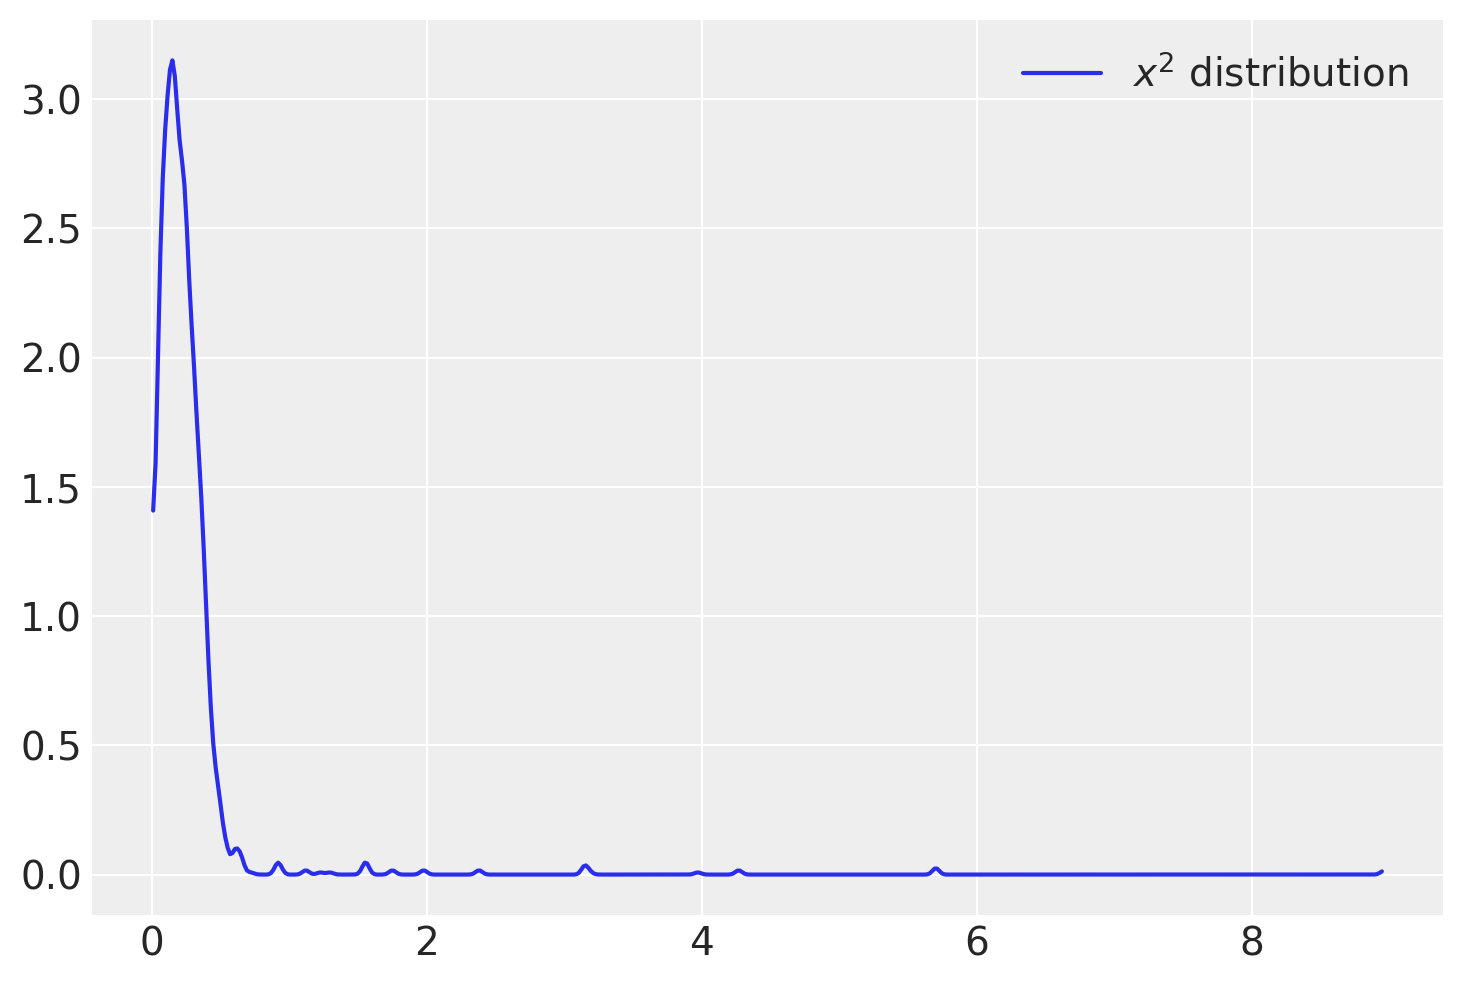

In [32]:
az.plot_kde(np.array([a_sample.eval() for _ in range(2000)]), label="$x^2$ distribution");

There is a more convinient way to get lots of samples at once: `sample_node`

In [33]:
a_samples = svgd_approx.sample_node(a, size=1000)

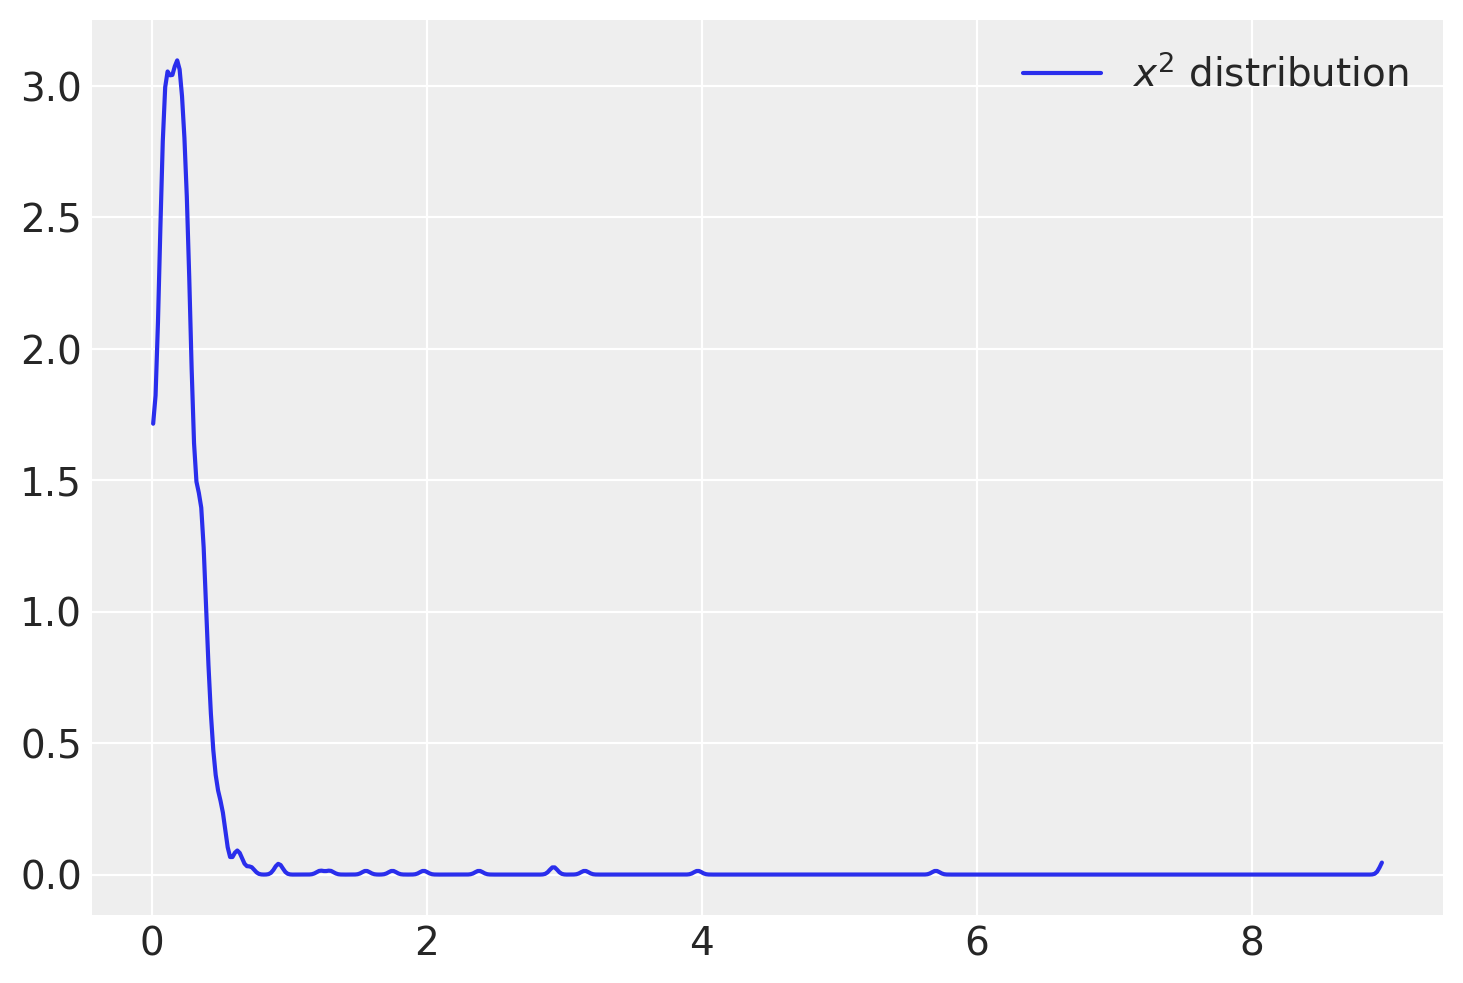

In [34]:
az.plot_kde(a_samples.eval(), label="$x^2$ distribution");

The `sample_node` function includes an additional dimension, so taking expectations or calculating variance is specified by `axis=0`.

In [35]:
a_samples.var(0).eval()  # variance

array(0.2875316)

In [36]:
a_samples.mean(0).eval()  # mean

array(0.24213133)

A symbolic sample size can also be specified:

In [37]:
i = theano.tensor.iscalar("i")
i.tag.test_value = 1
a_samples_i = svgd_approx.sample_node(a, size=i)

In [38]:
a_samples_i.eval({i: 100}).shape

(100,)

In [39]:
a_samples_i.eval({i: 10000}).shape

(10000,)

Unfortunately the size must be a scalar value.

### Converting a Trace to an Approximation

We can convert a MCMC trace into an Approximation. It will have the same API as approximations above with same `sample_node` methods:

In [40]:
trace_approx = pm.Empirical(trace, model=model)
trace_approx

We can then draw samples from the `Emipirical` object:

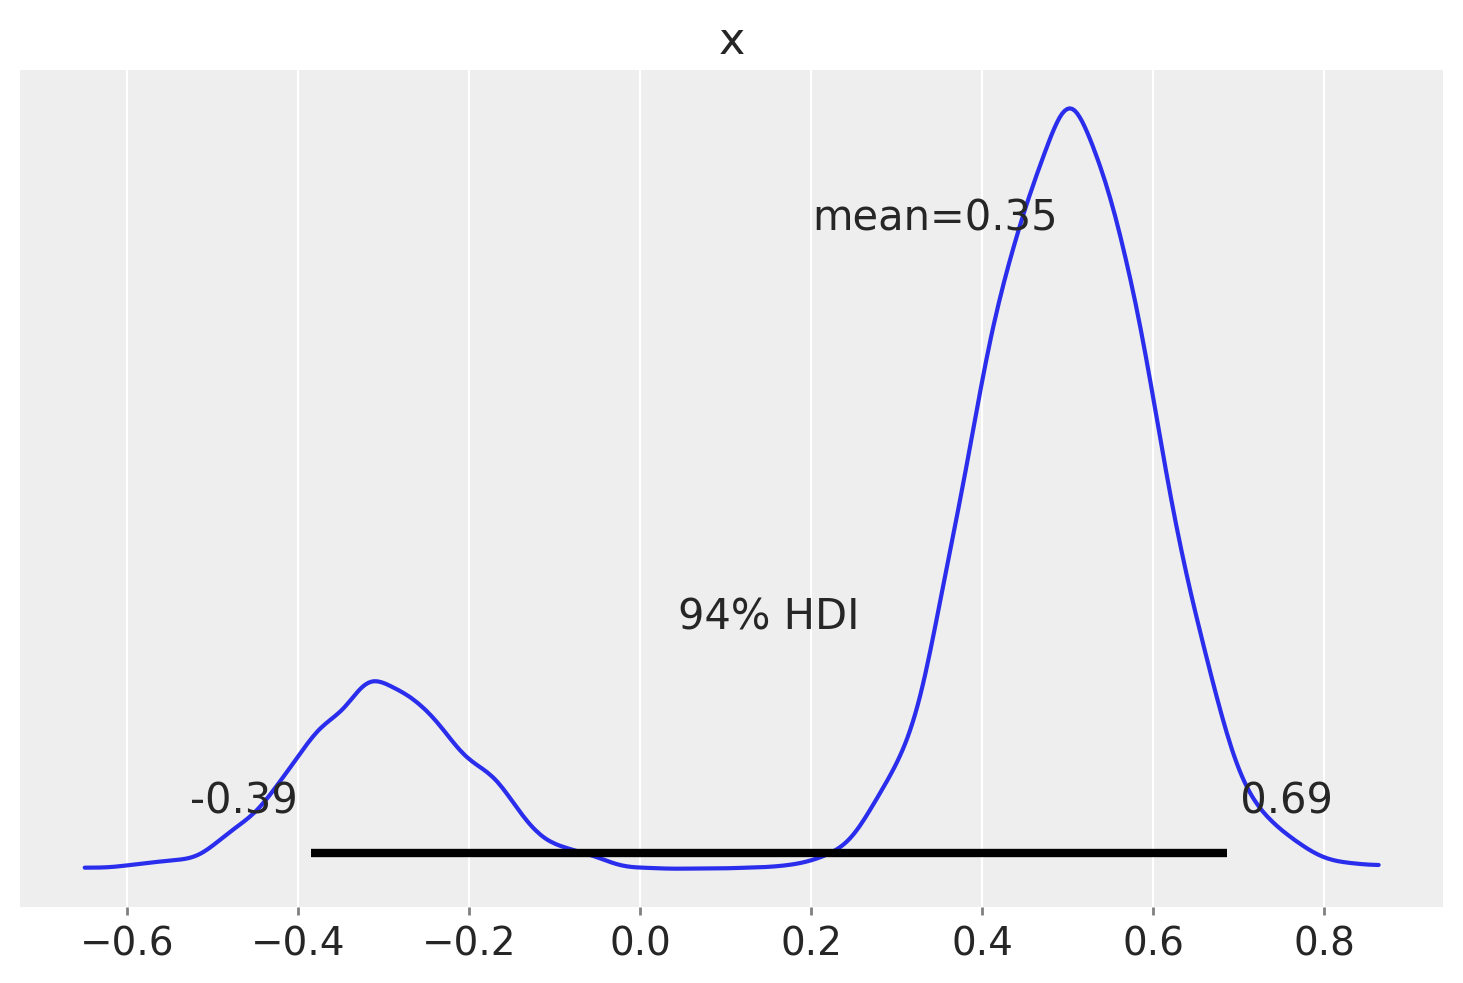

In [41]:
with model:
    az.plot_posterior(trace_approx.sample(10000));

## Multilabel logistic regression

Let's illustrate the use of `Tracker` with the famous Iris dataset. We'll attempy multi-label classification and compute the expected accuracy score as a diagnostic.

In [42]:
import pandas as pd
import theano.tensor as tt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

![](http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2015/04/iris_petal_sepal.png)

A relatively simple model will be sufficient here because the classes are roughly linearly separable; we are going to fit multinomial logistic regression.

In [43]:
Xt = theano.shared(X_train)
yt = theano.shared(y_train)

coords = {
    "obs_id": X_train.shape[0],
    "attr": X_train.shape[1],
    "class": np.unique(y_train).shape[0],
}

with pm.Model(coords=coords) as iris_model:

    # Coefficients for features
    β = pm.Normal("β", 0, sigma=1e2, dims=("attr", "class"))
    # Transoform to unit interval
    a = pm.Flat("a", dims="class")
    p = tt.nnet.softmax(Xt.dot(β) + a)

    observed = pm.Categorical("obs", p=p, observed=yt, dims="obs_id")

### Applying replacements in practice
PyMC3 models have symbolic inputs for latent variables. To evaluate an espression that requires knowledge of latent variables, one needs to provide fixed values. We can use values approximated by VI for this purpose. The function `sample_node` removes the symbolic dependenices. 

`sample_node` will use the whole distribution at each step, so we will use it here. We can apply more replacements in single function call using the `more_replacements` keyword argument in both replacement functions.

> **HINT:** You can use `more_replacements` argument when calling `fit` too:
>   * `pm.fit(more_replacements={full_data: minibatch_data})`
>   * `inference.fit(more_replacements={full_data: minibatch_data})`

In [44]:
with iris_model:

    # We'll use SVGD
    inference = pm.SVGD(n_particles=500, jitter=1)

    # Local reference to approximation
    approx = inference.approx

    # Here we need `more_replacements` to change train_set to test_set
    test_probs = approx.sample_node(p, more_replacements={Xt: X_test}, size=100)

    # For train set no more replacements needed
    train_probs = approx.sample_node(p)

By applying the code above, we now have 100 sampled probabilities (default number for `sample_node` is `None`) for each observation.

Next we create symbolic expressions for sampled accuracy scores:

In [45]:
test_ok = tt.eq(test_probs.argmax(-1), y_test)
train_ok = tt.eq(train_probs.argmax(-1), y_train)
test_accuracy = test_ok.mean(-1)
train_accuracy = train_ok.mean(-1)

Tracker expects callables so we can pass `.eval` method of theano node that is function itself. 

Calls to this function are cached so they can be reused.

In [46]:
eval_tracker = pm.callbacks.Tracker(
    test_accuracy=test_accuracy.eval, train_accuracy=train_accuracy.eval
)

In [47]:
inference.fit(100, callbacks=[eval_tracker]);

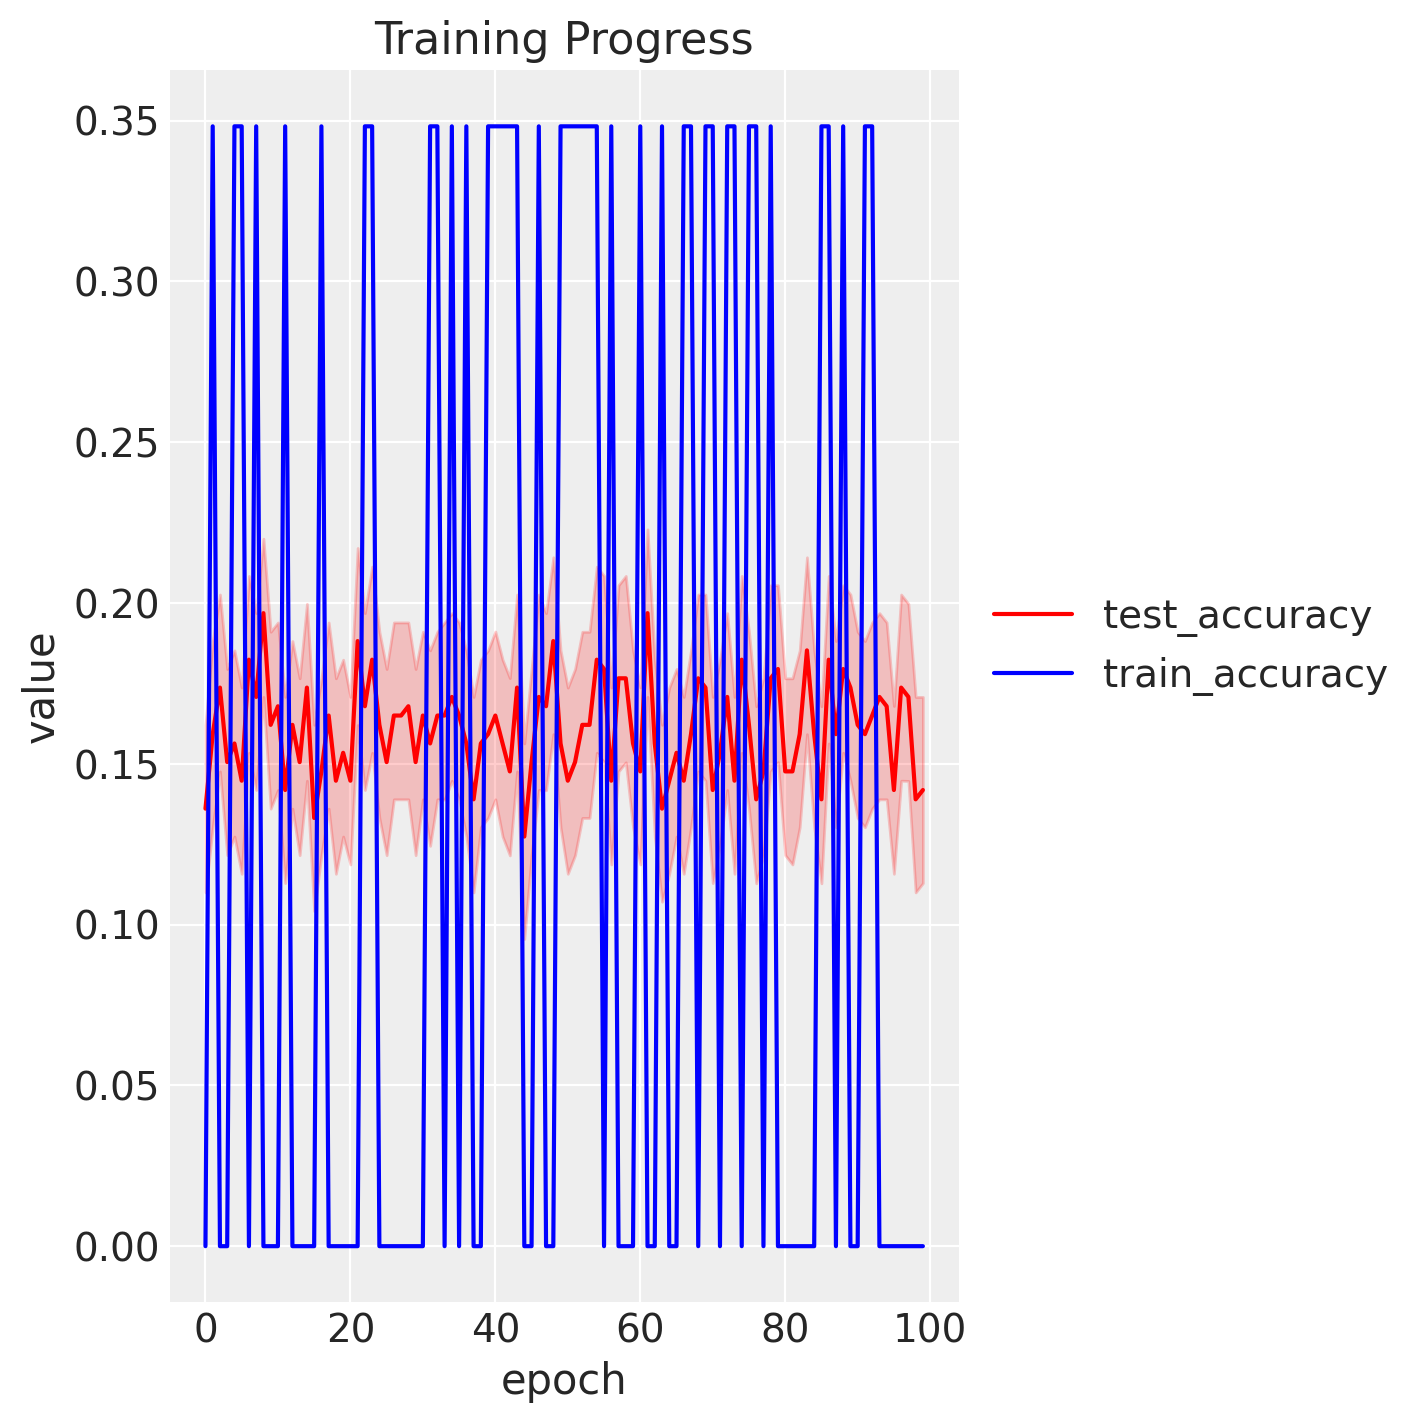

In [48]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))
df = pd.DataFrame(eval_tracker["test_accuracy"]).T.melt()
sns.lineplot(x="variable", y="value", data=df, color="red", ax=ax)
ax.plot(eval_tracker["train_accuracy"], color="blue")
ax.set_xlabel("epoch")
plt.legend(["test_accuracy", "train_accuracy"], bbox_to_anchor=(1.0, 0.6))
plt.title("Training Progress");

Training does not seem to be working here. Let's use a different optimizer and boost the learning rate.

In [49]:
inference.fit(400, obj_optimizer=pm.adamax(learning_rate=0.1), callbacks=[eval_tracker]);

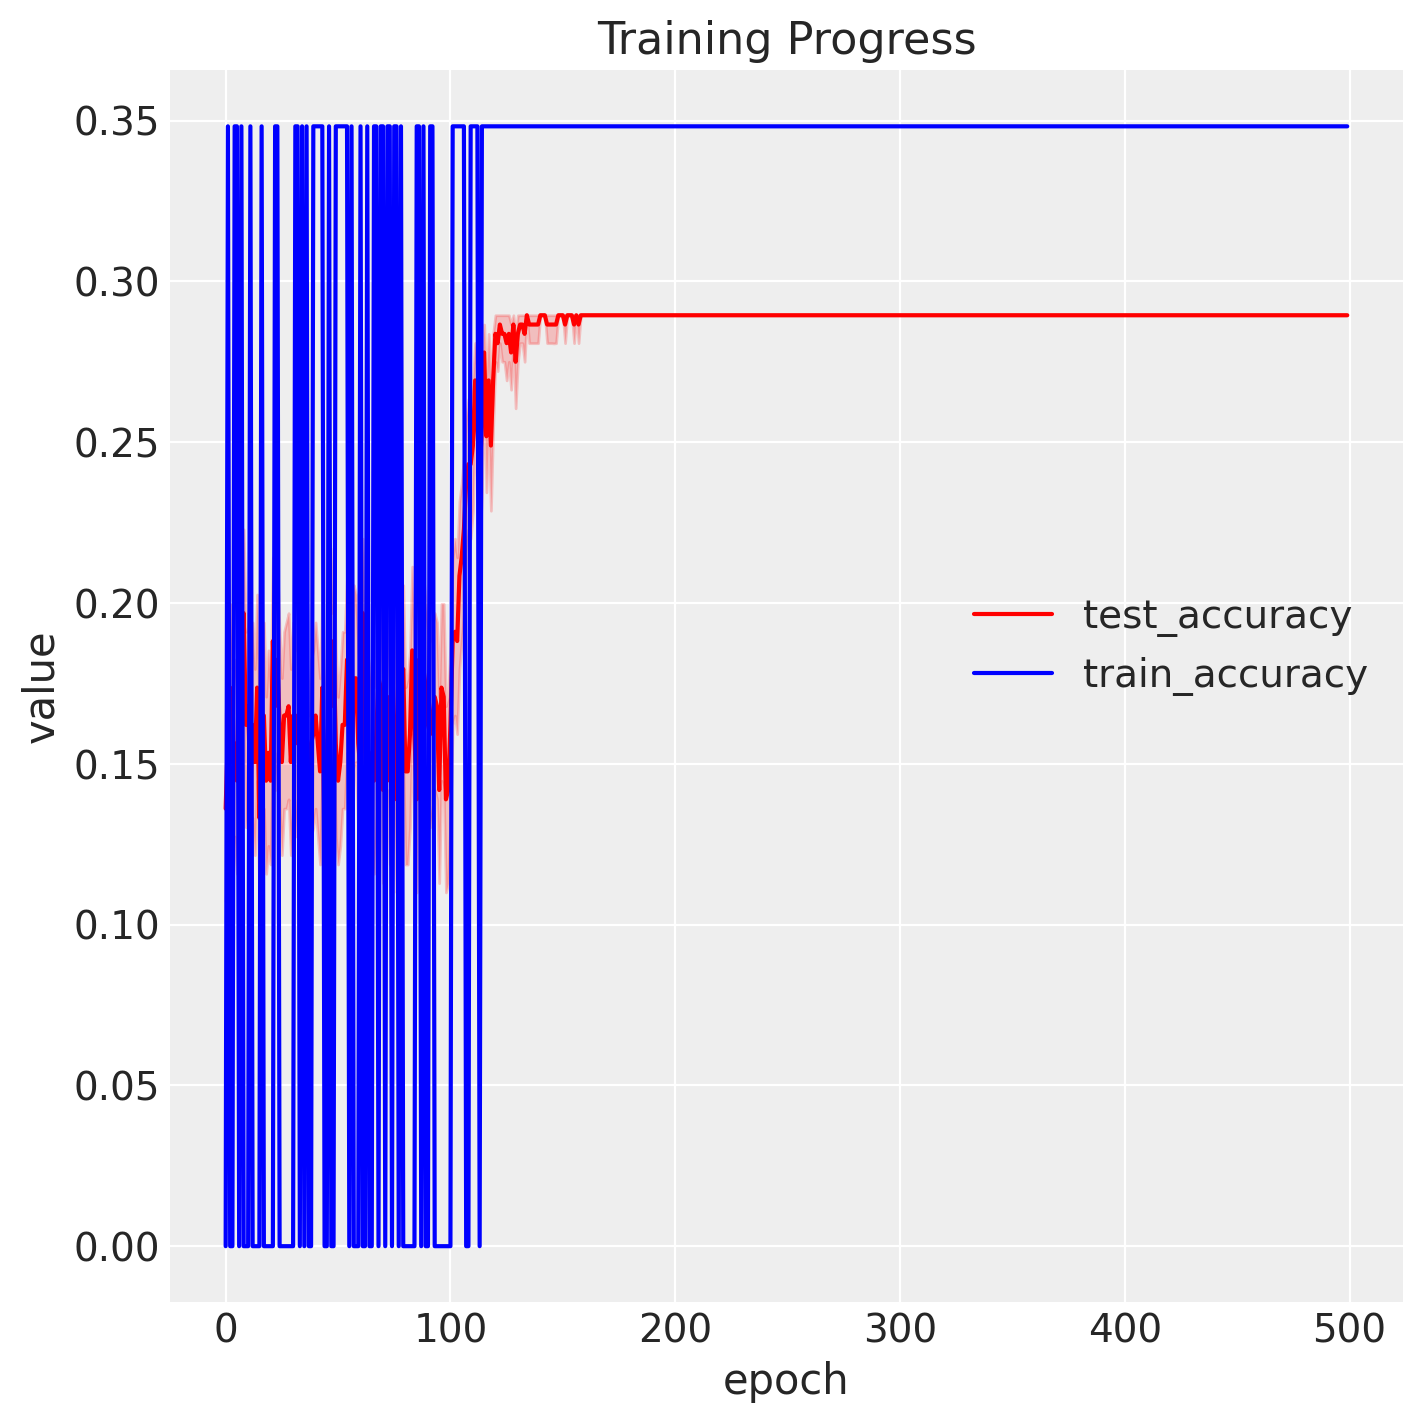

In [50]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))
df = pd.DataFrame(np.asarray(eval_tracker["test_accuracy"])).T.melt()
sns.lineplot(x="variable", y="value", data=df, color="red", ax=ax)
ax.plot(eval_tracker["train_accuracy"], color="blue")
ax.set_xlabel("epoch")
plt.legend(["test_accuracy", "train_accuracy"], bbox_to_anchor=(1.0, 0.6))
plt.title("Training Progress");

This is much better! 

So, `Tracker` allows us to monitor our approximation and choose good training schedule.

## Minibatches
When dealing with large datasets, using minibatch training can drastically speed up and improve approximation performance. Large datasets impose a hefty cost on the computation of gradients. 

There is a nice API in pymc3 to handle these cases, which is avaliable through the `pm.Minibatch` class. The minibatch is just a highly specialized Theano tensor:

In [51]:
issubclass(pm.Minibatch, theano.tensor.TensorVariable)

True

To demonstrate, let's simulate a large quantity of data:

In [52]:
# Raw values
data = rng.random((40000, 100))
# Scaled values
data *= rng.integers(1, 10, size=(100,))
# Shifted values
data += rng.random(100) * 10

For comparison, let's fit a model without minibatch processing:

In [53]:
coords = {"obs_id": data.shape[0], "col": data.shape[1]}

with pm.Model(coords=coords) as model:
    mu = pm.Flat("mu", dims="col")
    sd = pm.HalfNormal("sd", dims="col")
    lik = pm.Normal("lik", mu, sd, observed=data, dims="obs_id")

Just for fun, let's create a custom special purpose callback to halt slow optimization. Here we define a callback that causes a hard stop when approximation runs too slowly:

In [54]:
def stop_after_10(approx, loss_history, i):
    if (i > 0) and (i % 10) == 0:
        raise StopIteration("I was slow, sorry")

In [55]:
with model:
    advifit = pm.fit(callbacks=[stop_after_10])

I was slow, sorry
Interrupted at 9 [0%]: Average Loss = 5.3766e+08


Inference is too slow, taking several seconds per iteration; fitting the approximation would have taken hours!

Now let's use minibatches. At every iteration, we will draw 500 random values:

> Remember to set `total_size` in observed

**total_size** is an important parameter that allows pymc3 to infer the right way of rescaling densities. If it is not set, you are likely to get completely wrong results. For more information please refer to the comprehensive documentation of `pm.Minibatch`.

In [56]:
X = pm.Minibatch(data, batch_size=500)

with pm.Model(coords=coords) as model:

    mu = pm.Flat("mu", dims="col")
    sd = pm.HalfNormal("sd", dims="col")
    likelihood = pm.Normal("likelihood", mu, sd, observed=X, total_size=data.shape, dims="obs_id")

/home/ada/.local/lib/python3.8/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [57]:
with model:
    advifit = pm.fit()

Finished [100%]: Average Loss = 1.7016e+05


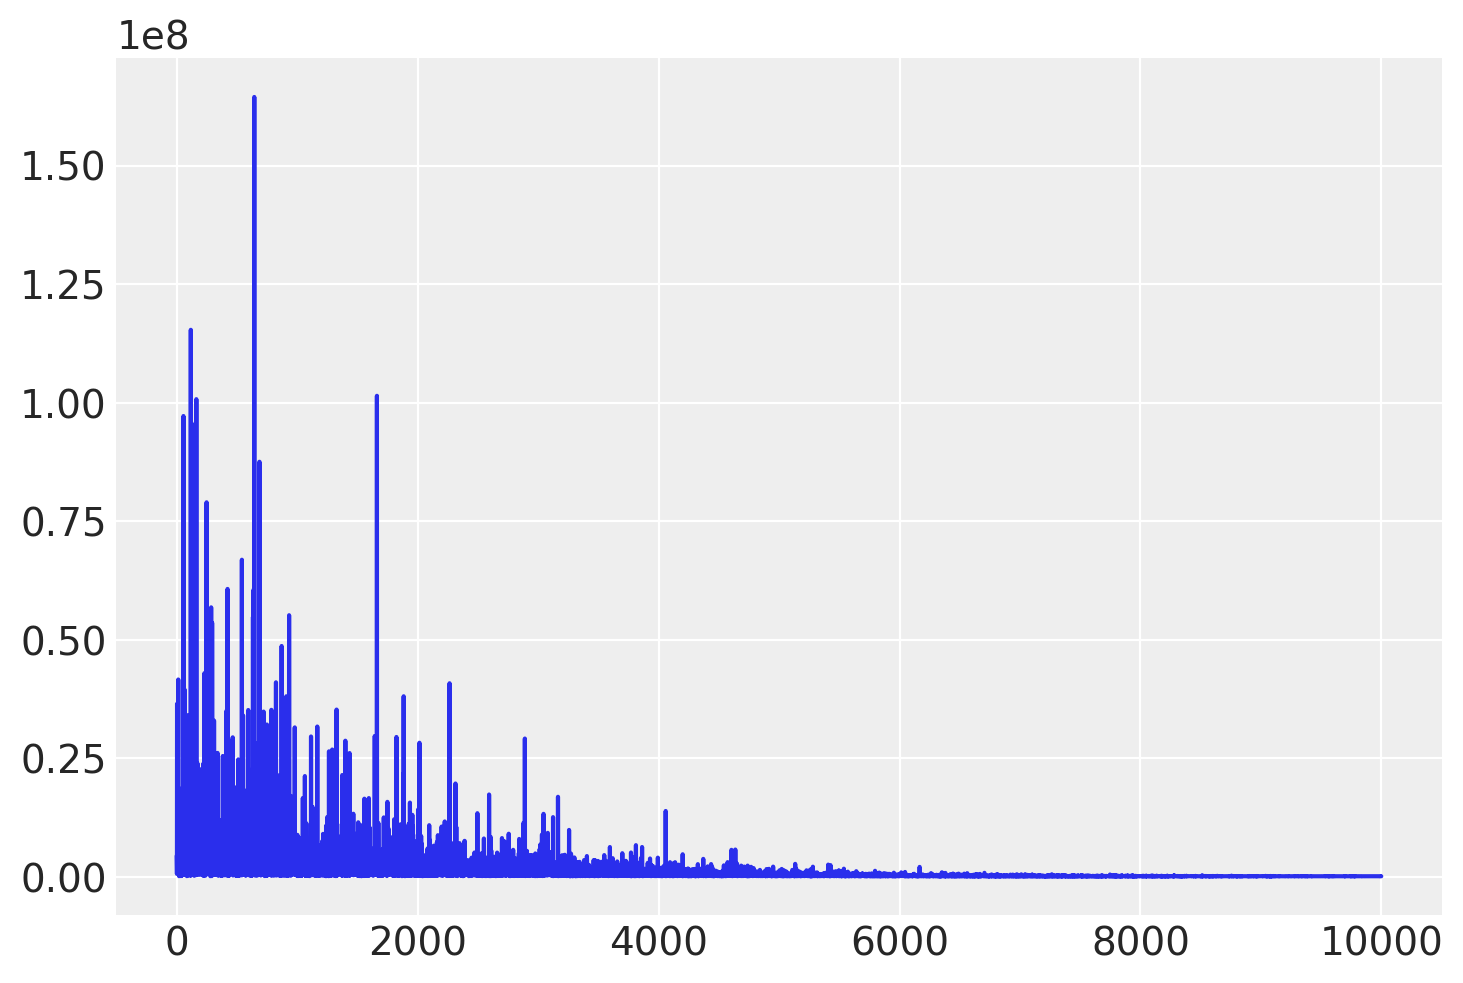

In [58]:
plt.plot(advifit.hist);

Minibatch inference is dramatically faster. Multidimensional minibatches may be needed for some corner cases where you do matrix factorization or model is very wide.

Here is the docstring for `Minibatch` to illustrate how it can be customized.

In [59]:
print(pm.Minibatch.__doc__)

Multidimensional minibatch that is pure TensorVariable

    Parameters
    ----------
    data: np.ndarray
        initial data
    batch_size: ``int`` or ``List[int|tuple(size, random_seed)]``
        batch size for inference, random seed is needed
        for child random generators
    dtype: ``str``
        cast data to specific type
    broadcastable: tuple[bool]
        change broadcastable pattern that defaults to ``(False, ) * ndim``
    name: ``str``
        name for tensor, defaults to "Minibatch"
    random_seed: ``int``
        random seed that is used by default
    update_shared_f: ``callable``
        returns :class:`ndarray` that will be carefully
        stored to underlying shared variable
        you can use it to change source of
        minibatches programmatically
    in_memory_size: ``int`` or ``List[int|slice|Ellipsis]``
        data size for storing in ``theano.shared``

    Attributes
    ----------
    shared: shared tensor
        Used for storing data
    m

## Watermark

In [60]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Thu Sep 16 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

xarray: 0.17.0

numpy     : 1.21.0
arviz     : 0.11.2
seaborn   : 0.11.1
theano    : 1.1.2
pymc3     : 3.11.2
pandas    : 1.2.1
matplotlib: 3.3.4

Watermark: 2.2.0

